In [1]:
import torch 
import meep as mp
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image

print("Cuda Device Available:", torch.cuda.is_available())
print("Device Count:", torch.cuda.device_count())
print("Device Current:", torch.cuda.current_device())

Cuda Device Available: True
Device Count: 1
Device Current: 0


In [2]:
class AntennaImageDatasetV2(Dataset): 
    def __init__(self, folder_path): 
        self.label_path = os.path.join(folder_path, 'labels')
        self.input_path = os.path.join(folder_path, 'x')
        self.len = None
        
    def __len__(self): 
        if self.len == None: 
            self.len = 0
            for name in os.listdir(self.label_path):
                if ".npy" in name: 
                    self.len += 1
        return self.len
        
    def __getitem__(self, idx): 
        input_path = os.path.join(self.input_path, 'train_%04d.npy' % idx)
        label_path = os.path.join(self.label_path, 'train_%04d_label.npy' % idx)
        
        sources_img = torch.Tensor(np.load(input_path))[0]
        label_img = torch.Tensor(np.load(label_path))
        
        return sources_img[..., None], label_img[..., None]

/home/winnaries/miniconda3/envs/rebel/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/winnaries/miniconda3/envs/rebel/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


(torch.Size([140, 140, 1]), torch.Size([140, 140, 1]), 2000)

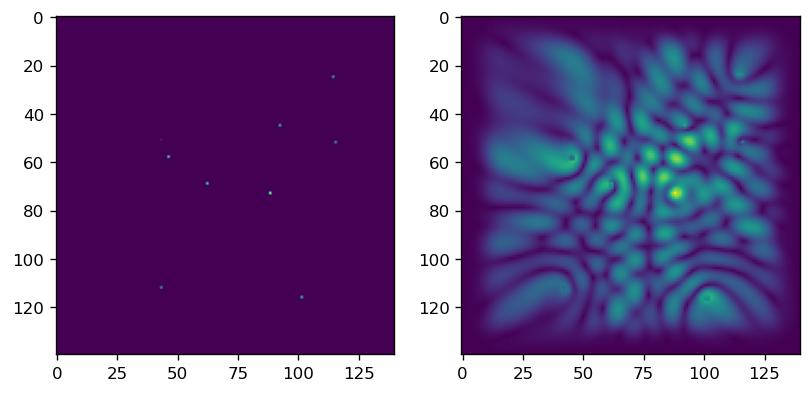

In [3]:
datasets = AntennaImageDatasetV2('./data_v3')
demo_sources, demo_label = datasets[192]

fig, axes = plt.subplots(1, 2, dpi=120, figsize=(8, 8))
axes[0].imshow(demo_sources)
axes[1].imshow(demo_label)

demo_sources.shape, demo_label.shape, len(datasets)

In [4]:
torch.manual_seed(123)
train_datasets, test_datasets = random_split(datasets, [1760, 240])
train_dataloader = DataLoader(train_datasets, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_datasets, batch_size=32, shuffle=True)

In [5]:
class DoubleConv(nn.Module): 
    
    def __init__(self, in_channels, out_channels, mid_channels=None): 
        super().__init__()
        if not mid_channels: 
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False), 
            nn.BatchNorm2d(mid_channels), 
            nn.ReLU(inplace=True), 
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True), 
        )
        
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module): 
    
    def __init__(self, in_channels, out_channels): 
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), 
            DoubleConv(in_channels, out_channels),
        )
        
    def forward(self, x): 
        return self.maxpool_conv(x)
    
class Up(nn.Module): 
    
    def __init__(self, in_channels, out_channels, bilinear=True): 
        super().__init__()
        
        if bilinear: 
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2): 
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, 
                        diffY // 2, diffY - diffY // 2])
                
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
        
    
class OutConv(nn.Module):
    
    def __init__(self, in_channels, out_channels): 
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x): 
        return self.conv(x)


In [6]:
class UNet(nn.Module): 

    def __init__(self, n_channels): 
        super().__init__()
        self.n_channels = n_channels
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512, False)
        self.up2 = Up(512, 256, False)
        self.up3 = Up(256, 128, False)
        self.up4 = Up(128, 64, False)
        self.outc = OutConv(64, 1)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x
    
    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [9]:
model = UNet(1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [8]:
epochs = 100
train_losses = []
test_losses = []
best = 100000000

for epoch in range(epochs): 
    train_loss = 0
    test_loss = 0
    
    pbar = tqdm(enumerate(iter(train_dataloader)), total=len(train_dataloader),
                desc="Train Epoch %d" % epoch, ncols=100)
    
    model.train()
    for i, (x, y) in pbar: 
        x = x.cuda().permute(0, 3, 1, 2)
        y = y.cuda().permute(0, 3, 1, 2)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = F.mse_loss(y, y_hat)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.set_postfix({'train_loss': train_loss / (i + 1)})
        
    model.eval()
    with torch.no_grad(): 
        pbar = tqdm(iter(test_dataloader), desc="Test Epoch %d" % epoch, ncols=100)
        
        for (x, y) in pbar: 
            x = x.cuda().permute(0, 3, 1, 2)
            y = y.cuda().permute(0, 3, 1, 2)
            y_hat = model(x)
            loss = F.mse_loss(y, y_hat)
            test_loss += loss.item()
            pbar.set_postfix({'test_loss': test_loss})
            
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    if test_loss < best: 
        best = test_loss
        torch.save(model.state_dict(), "checkpoints/unet-best.pt")

Train Epoch 28:  89%|████████████████████████   | 49/55 [00:33<00:04,  1.45it/s, train_loss=0.00196]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
model.load_state_dict(torch.load("checkpoints/unet-best.pt"))

<All keys matched successfully>

torch.Size([1, 1, 140, 140]) torch.Size([1, 140, 140])
torch.Size([1, 1, 140, 140]) torch.Size([1, 140, 140])
torch.Size([1, 1, 140, 140]) torch.Size([1, 140, 140])
torch.Size([1, 1, 140, 140]) torch.Size([1, 140, 140])
torch.Size([1, 1, 140, 140]) torch.Size([1, 140, 140])
torch.Size([1, 1, 140, 140]) torch.Size([1, 140, 140])
torch.Size([1, 1, 140, 140]) torch.Size([1, 140, 140])
torch.Size([1, 1, 140, 140]) torch.Size([1, 140, 140])
torch.Size([1, 1, 140, 140]) torch.Size([1, 140, 140])
torch.Size([1, 1, 140, 140]) torch.Size([1, 140, 140])


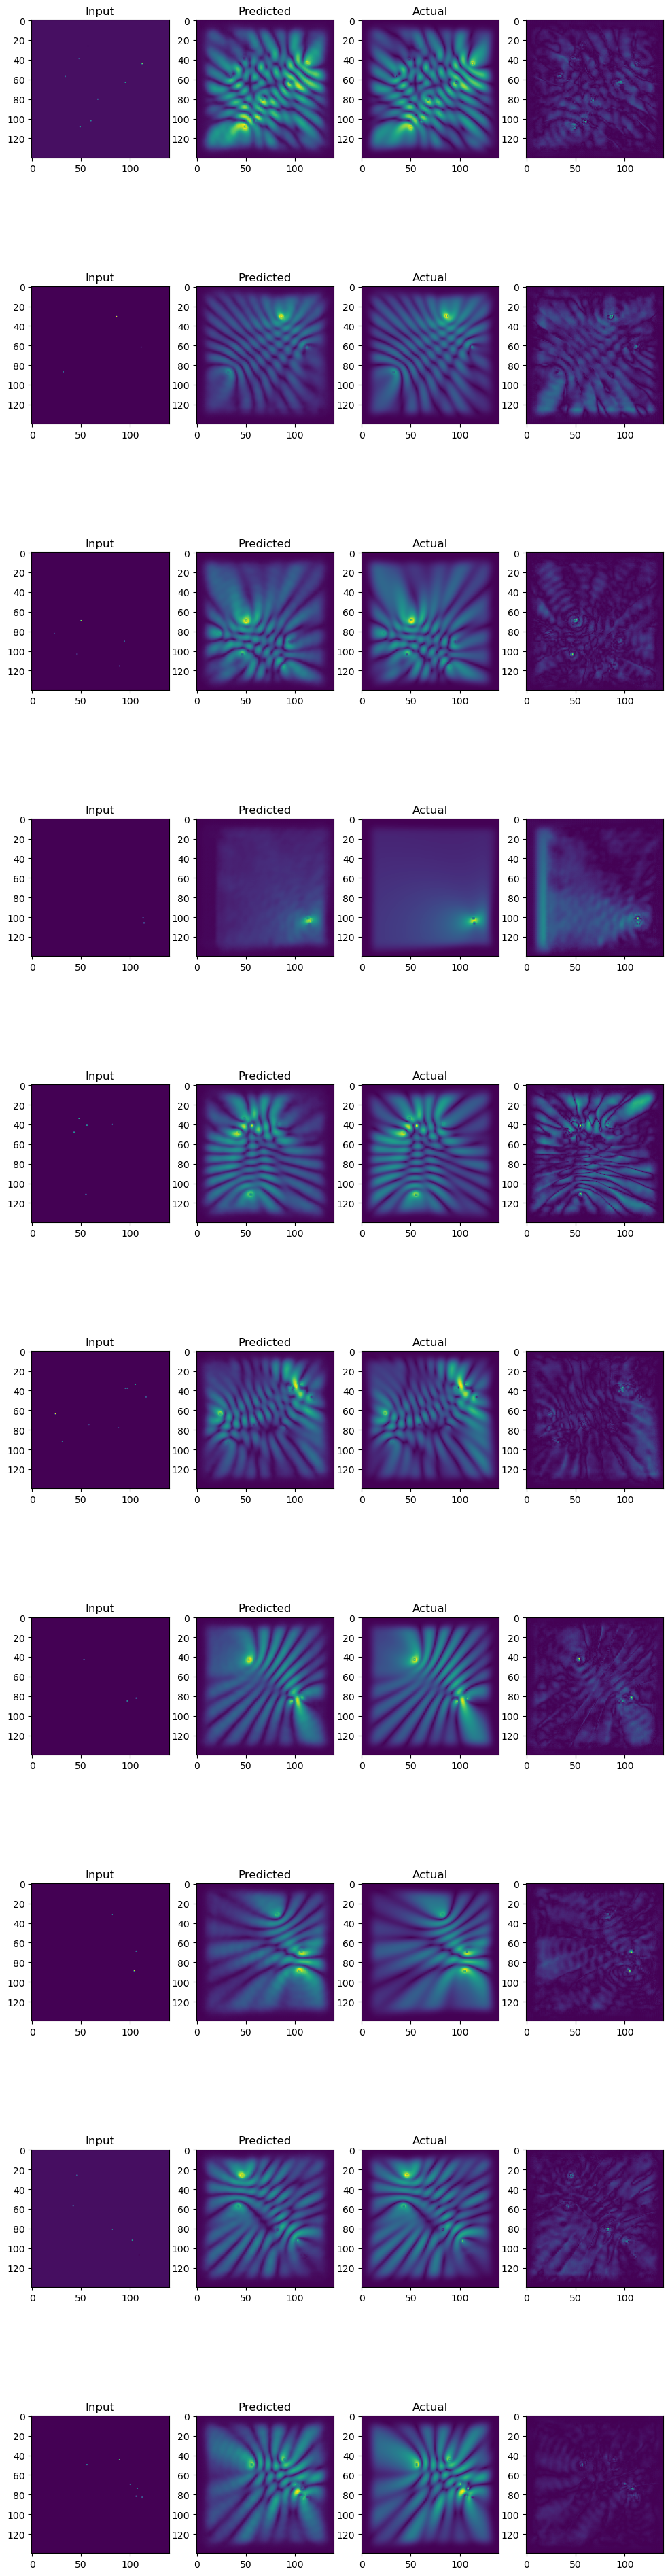

In [33]:
fig, axes = plt.subplots(10, 4, figsize=(12, 50))
begin = 10

with torch.no_grad(): 
    for i in range(10): 
        x, y = test_datasets[begin + i]
        x = x.permute(2, 0, 1)[None]
        y_hat = model(x).squeeze(0)
        
        print(x.shape, y_hat.shape)
        
        x = x.squeeze(0).permute(1, 2, 0).cpu()
        y_hat = y_hat.permute(1, 2, 0).cpu()
        
        x = x / x.max()
        y = y / y.max()
        y_hat = y_hat / y_hat.max()
        
        axes[i, 0].imshow(x)
        axes[i, 1].imshow(y_hat)
        axes[i, 2].imshow(y)
        axes[i, 3].imshow(np.abs(y_hat - y))
        
        axes[i, 0].set_title("Input")
        axes[i, 1].set_title("Predicted")
        axes[i, 2].set_title("Actual")
        
fig.savefig("unet_demo.png", facecolor="white")

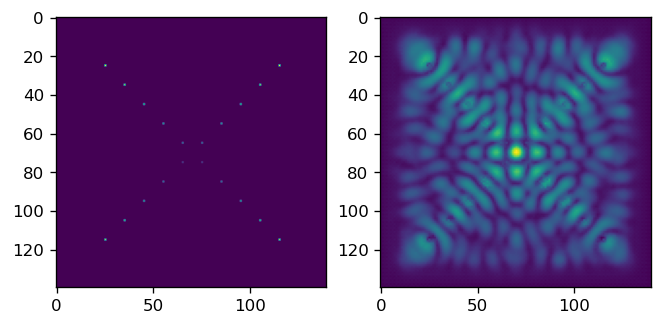

In [36]:
with torch.no_grad(): 
    x = np.zeros((1, 1, 140, 140))
    
    for i in range(10): 
        idx = 25 + i * 10
        x[:, :, idx, idx] = 0.2 + abs(i - 5) * 0.2
        x[:, :, idx, 140 - idx] = 0.2 + abs(i - 5) * 0.2
        
    x = torch.Tensor(x)
    y = model(x)
    fig, axes = plt.subplots(1, 2, dpi=120)
    axes[0].imshow(x.cpu().squeeze(0).permute(1, 2, 0))
    axes[1].imshow(y.cpu().squeeze(0).permute(1, 2, 0))